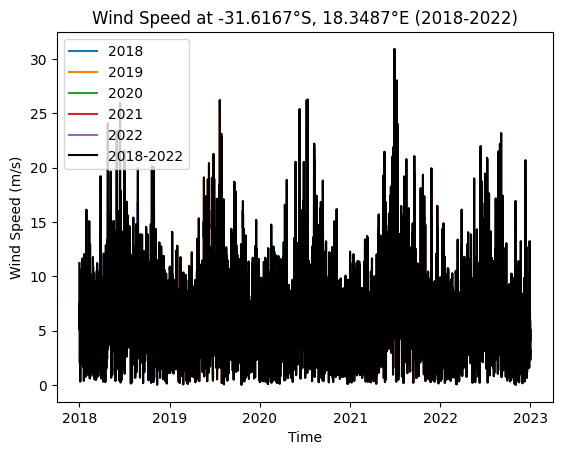

In [ ]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt

# # Coordinates of Sere Wind Farm
# sere_lat = -31.6167
# sere_lon = 18.3487

# # Lists to collect data for all years
# all_wind_speeds = []
# all_times = []

# # Loop over each year and extract data
# for year in range(2018, 2023):
#     # Open dataset for the specific year
#     ds = xr.open_dataset(f'data_850/{year}_850_SA.nc')
#     ds.load()

#     # Calculate wind speed from u and v components
#     ds['wspd'] = np.sqrt(ds.u**2 + ds.v**2).astype(np.float32)

#     # Select the data closest to the Sere Wind Farm coordinates
#     sere_wind_data = ds.sel(latitude=sere_lat, longitude=sere_lon, method='nearest')

#     # Extract time and wind speed as numpy arrays
#     sere_wind_time = sere_wind_data['time'].values
#     sere_wind_np = sere_wind_data['wspd'].values

#     # Collect the data for concatenation
#     all_times.append(sere_wind_time)
#     all_wind_speeds.append(sere_wind_np)

#     # Plot the wind speed for the current year
#     plt.plot(sere_wind_time, sere_wind_np, label=f'{year}')

# # Concatenate all years' data into one array for a combined plot
# all_times = np.concatenate(all_times)
# all_wind_speeds = np.concatenate(all_wind_speeds)

# # Plotting the combined data for all years
# plt.plot(all_times, all_wind_speeds, label='2018-2022', color='black')

# plt.xlabel('Time')
# plt.ylabel('Wind Speed (m/s)')
# plt.title(f'Wind Speed at {sere_lat}°S, {sere_lon}°E (2018-2022)')
# plt.legend()
# plt.show()




In [ ]:
# df = pd.DataFrame({
#     'Time': all_times,
#     'Wind Speed (m/s)': all_wind_speeds
# })

# # Save the DataFrame to a CSV file
# df.to_csv('sere_wind_speeds_2018_2022.csv', index=False)

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import Trainer

df = pd.read_csv('data_850\sere_wind_speeds_2018_2022.csv')

In [128]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=10, steps_ahead=1, data_split='train', intervals = 1):
        self.window_size = window_size
        self.steps_ahead = steps_ahead
        self.df = df

        self.mean = self.df['wspd'].mean()
        self.std = self.df['wspd'].std()

        self.data_split = data_split

        self.interval = intervals

        self.split_data()
        self.normalize_data()

    def __len__(self):
        if self.data_split == 'train':
            dataset_length = len(self.X_train)
        elif self.data_split == 'val':
            dataset_length = len(self.X_val)
        elif self.data_split == 'test':
            dataset_length = len(self.X_test)
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
        
        total_window_size = self.window_size + self.steps_ahead
        num_windows = dataset_length - total_window_size + 1  
        
        return max(0, num_windows) 

    def __getitem__(self, idx):
        """
        Retrieves a sample from the specified dataset split.

        Args:
            idx (int): The index of the sample to retrieve.
            data_split (str): The dataset split ('train', 'val', 'test'). Default is 'train'.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing features, forcings, and target.
        """
        if self.data_split == 'train':
            return self.X_train_t[idx:idx+self.window_size:self.interval], self.F_train_t[idx + self.window_size], self.X_train_t[idx + self.window_size:idx + self.window_size + self.steps_ahead:self.interval]
        elif self.data_split == 'val':
            return self.X_val_t[idx:idx+self.window_size:self.interval], self.F_val_t[idx + self.window_size], self.X_val_t[idx + self.window_size:idx + self.window_size + self.steps_ahead:self.interval]
        elif self.data_split == 'test':
            return self.X_test_t[idx:idx+self.window_size:self.interval], self.F_test_t[idx + self.window_size], self.X_test_t[idx + self.window_size:idx + self.window_size + self.steps_ahead:self.interval]
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
 
    def split_data(self, train_size=0.8, val_size=0.1):
        wspd_data = self.df['wspd']
        time_values = df['Time'].values
        time_values = pd.to_datetime(time_values)

        forcings = np.stack([time_values.hour, time_values.month], axis=-1)

        self.X_train, self.X_test = train_test_split(wspd_data, train_size=train_size, shuffle=False)
        self.X_train, self.X_val = train_test_split(self.X_train, test_size=val_size, shuffle=False)

        self.F_train, self.F_test = train_test_split(forcings, train_size=train_size, shuffle=False)
        self.F_train, self.F_val = train_test_split(self.F_train, test_size=val_size, shuffle=False)        

    def normalize_data(self):
        
        self.X_train_t = (self.X_train - self.mean) / self.std
        self.X_val_t = (self.X_val - self.mean) / self.std
        self.X_test_t = (self.X_test - self.mean) / self.std

        self.X_train_t = torch.tensor(self.X_train_t.values, dtype=torch.float32)
        self.X_val_t = torch.tensor(self.X_val_t.values, dtype=torch.float32)
        self.X_test_t = torch.tensor(self.X_test_t.values, dtype=torch.float32)

        self.F_train_t = torch.tensor(self.F_train, dtype=torch.float32)
        self.F_val_t = torch.tensor(self.F_val, dtype=torch.float32)
        self.F_test_t = torch.tensor(self.F_test, dtype=torch.float32)

    def plot_predictions(self, model, seed = 0):
        x = self.X_test_t[seed:seed+self.window_size:self.interval]
        F = self.F_test_t[seed + self.window_size]
        y = self.X_test_t[seed + self.window_size:seed + self.window_size + self.steps_ahead:self.interval]

        predictions = self.auto_regressive(model, x, F)

        plt.plot(range(self.window_size), x)
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), y)
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), predictions.detach().numpy())
        plt.show()

    def auto_regressive(self, model, x, F):
        predictions = []
        for i in range(round(self.steps_ahead / self.interval)):
            y_hat = model(x, F)

            x = torch.cat([x[1:], y_hat], dim=-1)
            
            predictions.append(y_hat)

        return torch.stack(predictions)

In [124]:
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, forcing_size, output_size, lr = 0.0001, steps = 1):
        super(SimpleMLP, self).__init__()
        self.save_hyperparameters()

        self.fc1 = nn.Linear(input_size + forcing_size, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, output_size) 

        self.loss_fn = nn.MSELoss()

        self.steps = steps

        self.lr = lr

    def forward(self, X, F):
        inputs = torch.cat((X, F), dim=-1)  

        x = torch.relu(self.fc1(inputs)) 
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  

        return x
    
    def training_step(self, batch, batch_idx):
        x, F, y = batch  

        loss = self.auto_rollout(x, F, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, F, y = batch  
 
        loss = self.auto_rollout(x, F, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True) 
        return loss
    
    def auto_rollout(self, x, F, y):

        cumulative_loss = 0.0
        current_input = x.clone()
        current_F = F.clone()


        for step in range(self.steps): 
            # print('Step: ', step)
            
            y_hat = self(current_input, current_F)

            loss = self.loss_fn(y_hat, y[:, step])
            cumulative_loss += loss  
            
            current_input = torch.cat((current_input[:, 1:], y_hat), dim=1)

            hour = current_F[:, 0]
            month = current_F[:, 1]
            
            hour = (hour + 1) % 24

            current_F = torch.stack((hour, month), dim=1).float()

        return cumulative_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr= self.lr)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

In [125]:
window_size = 48
steps_ahead = 24
interval = 1

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, intervals=interval)

model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=1, lr=0.0001, steps=steps_ahead)

In [119]:
train_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval), batch_size=32, shuffle=True)  
val_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='val', intervals=interval), batch_size=32, shuffle=False)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='best_time_series',  save_top_k=1, mode='min')
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')

trainer = Trainer(max_epochs=100, callbacks=[checkpoint_callback, early_stop_callback])

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 6.5 K 
1 | fc2     | Linear  | 8.3 K 
2 | fc3     | Linear  | 65    
3 | loss_fn | MSELoss | 0     
------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_w

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


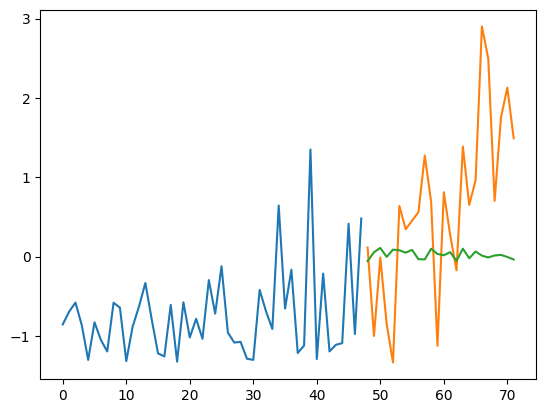

In [126]:
time_series.plot_predictions(model, seed=0)